## Set Up Dependencies


In [1]:
import datetime
import os

from cliffs_delta import cliffs_delta
import pandas as pd
import pecking
import matplotlib as mpl
import pecking
from slugify import slugify
from teeplot import teeplot as tp

from pylib._describe_effect import describe_effect
from pylib._styler_to_pdf import styler_to_pdf


## Data Retrieval and Preprocessing


In [2]:
df = pd.read_parquet("https://osf.io/ah7v5/download")


In [3]:
df["Num Reconstructed Inner Nodes"] = df["num_reconstructed_inner_nodes"]
df["Num True Inner Nodes"] = df["num_true_inner_nodes"]
df["Raw Triplet Distance"] = df["triplet_distance_raw"]
df["Sampled Triplet Distance Strict Reconst"] = df[
    "sampled_triplet_distance_strict_reconst"
]
df["Strict Triplet Distance"] = df["sampled_triplet_distance_strict"]
df["Lax Triplet Distance"] = df["sampled_triplet_distance_lax"]
df["Differentia Width (bits)"] = df["differentia_width_bits"]
df["Annotation Size (bits)"] = df["annotation_size_bits"]
df["Algorithm"] = df["algorithm"]
df["Population Size"] = df["population_size"]
df["Num Generations"] = df["num_generations"]
df["Num Islands"] = df["num_islands"]
df["Num Niches"] = df["num_niches"]
df["Tournament Size"] = df["tournament_size"]
df["Replicate"] = df["replicate"]
df["Downsample"] = df["downsample"]


In [4]:
df["Inner Node Resolution"] = (
    df["Num Reconstructed Inner Nodes"] / df["Num True Inner Nodes"]
)
df["Inner Node Loss"] = 1 - df["Inner Node Resolution"]


In [5]:
df["Dynamics"] = (
    "islands"
    + df["Num Islands"].astype(str)
    + "-niches"
    + df["Num Niches"].astype(str)
    + "-tsize"
    + df["Tournament Size"].astype(str)
)


In [6]:
df["Scale"] = (
    "npop"
    + df["Population Size"].astype(str)
    + "-ngen"
    + df["Num Generations"].astype(str)
)


In [7]:
df["Scenario"] = df["Dynamics"].map(
    {
        "islands1-niches1-tsize2": "plain",
        "islands1-niches1-tsize1": "drift",
        "islands4-niches2-tsize2": "mild\nstructure",
        "islands64-niches8-tsize2": "rich\nstructure",
    }
)


In [8]:
df["Policy"] = df["Algorithm"].map(
    {
        "surf-tilted": "Tilted",
        "col-tilted": "Tilted",
        "surf-hybrid": "Hybrid",
        "surf-steady": "Steady",
        "col-steady": "Steady",
    }
)


In [9]:
df["Implementation"] = df["Algorithm"].map(
    {
        "surf-tilted": "Surface",
        "col-tilted": "Column",
        "surf-hybrid": "Surface",
        "surf-steady": "Surface",
        "col-steady": "Column",
    }
)


In [10]:
for col in df.columns:
    df[col.replace(" ", "\n")] = df[col]


In [11]:
sensitivity_analysis_variables = [
    "Differentia\nWidth\n(bits)",
    "Algorithm",
    # "Num\nGenerations",
    "Annotation\nSize\n(bits)",
]


In [12]:
dfx = df.melt(
    id_vars=[
        "Algorithm",
        "Annotation Size (bits)",
        "Annotation\nSize\n(bits)",
        "annotation_size_bits",
        "Differentia Width (bits)",
        "Differentia\nWidth\n(bits)",
        "differentia_width_bits",
        "Downsample",
        "downsample",
        "Dynamics",
        "Implementation",
        "Policy",
        "Scenario",
        "Scale",
        "Population Size",
        "Population\nSize",
        "population_size",
        "Num Generations",
        "Num\nGenerations",
        "num_generations",
        "Num Islands",
        "Num Niches",
        "Tournament Size",
        "Replicate",
    ],
    value_vars=[
        "Strict\nTriplet\nDistance",
        "Lax\nTriplet\nDistance",
        "Inner\nNode\nLoss",
    ],
)
dfx.head()


,Algorithm,Annotation Size (bits),Annotation\nSize\n(bits),annotation_size_bits,Differentia Width (bits),Differentia\nWidth\n(bits),differentia_width_bits,Downsample,downsample,Dynamics,...,population_size,Num Generations,Num\nGenerations,num_generations,Num Islands,Num Niches,Tournament Size,Replicate,variable,value
0,col-steady,256,256,256,8,8,8,500,500,islands4-niches2-tsize2,...,4096,100000,100000,100000,4,2,2,4,Strict\nTriplet\nDistance,1.000000
1,col-steady,256,256,256,8,8,8,500,500,islands4-niches2-tsize2,...,4096,100000,100000,100000,4,2,2,12,Strict\nTriplet\nDistance,1.000000
2,col-steady,256,256,256,8,8,8,500,500,islands4-niches2-tsize2,...,4096,100000,100000,100000,4,2,2,2,Strict\nTriplet\nDistance,1.000000
3,col-steady,256,256,256,8,8,8,500,500,islands4-niches2-tsize2,...,4096,100000,100000,100000,4,2,2,19,Strict\nTriplet\nDistance,0.259036
4,col-steady,256,256,256,8,8,8,500,500,islands4-niches2-tsize2,...,4096,100000,100000,100000,4,2,2,1,Strict\nTriplet\nDistance,1.000000


## Visualize Main Metrics -- Population Size


teeplots/algorithm=surf-hybrid+annotation-size-bits=+col=num-generations+differentia-width-bits=+hue=population-size+post=teed-figure-subplots-adjust-right-0-75-teed-set-titles-row-template-row-name+row=variab.../le+score=value+viz=peckplot+x=scenario+x-group=outer+y=value+ext=.pdf


teeplots/algorithm=surf-hybrid+annotation-size-bits=+col=num-generations+differentia-width-bits=+hue=population-size+post=teed-figure-subplots-adjust-right-0-75-teed-set-titles-row-template-row-name+row=variab.../le+score=value+viz=peckplot+x=scenario+x-group=outer+y=value+ext=.png


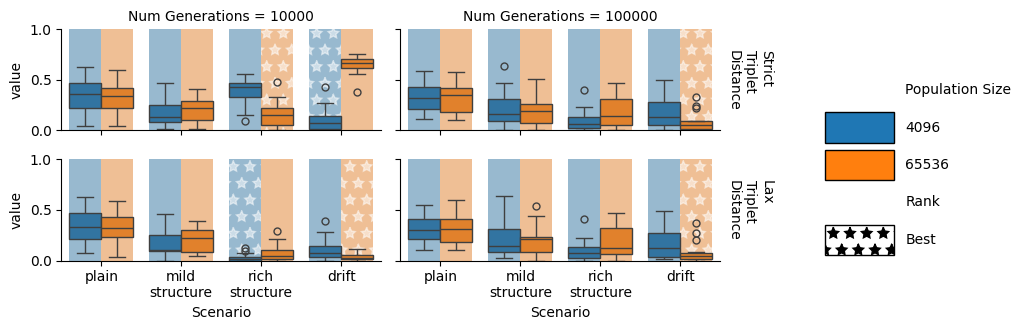

{'Differentia\nWidth\n(bits)': 1,
 'Algorithm': 'surf-hybrid',
 'Annotation\nSize\n(bits)': 32}

/home/runner/.local/lib/python3.10/site-packages/teeplot/teeplot.py:321: UserWarning: teeplot already created file teeplots/algorithm=surf-hybrid+annotation-size-bits=+col=num-generations+differentia-width-bits=+hue=population-size+post=teed-figure-subplots-adjust-right-0-75-teed-set-titles-row-template-row-name+row=variab.../le+score=value+viz=peckplot+x=scenario+x-group=outer+y=value+ext=.pdf, overwriting it
  warnings.warn(


teeplots/algorithm=surf-hybrid+annotation-size-bits=+col=num-generations+differentia-width-bits=+hue=population-size+post=teed-figure-subplots-adjust-right-0-75-teed-set-titles-row-template-row-name+row=variab.../le+score=value+viz=peckplot+x=scenario+x-group=outer+y=value+ext=.pdf


/home/runner/.local/lib/python3.10/site-packages/teeplot/teeplot.py:321: UserWarning: teeplot already created file teeplots/algorithm=surf-hybrid+annotation-size-bits=+col=num-generations+differentia-width-bits=+hue=population-size+post=teed-figure-subplots-adjust-right-0-75-teed-set-titles-row-template-row-name+row=variab.../le+score=value+viz=peckplot+x=scenario+x-group=outer+y=value+ext=.png, overwriting it
  warnings.warn(


teeplots/algorithm=surf-hybrid+annotation-size-bits=+col=num-generations+differentia-width-bits=+hue=population-size+post=teed-figure-subplots-adjust-right-0-75-teed-set-titles-row-template-row-name+row=variab.../le+score=value+viz=peckplot+x=scenario+x-group=outer+y=value+ext=.png


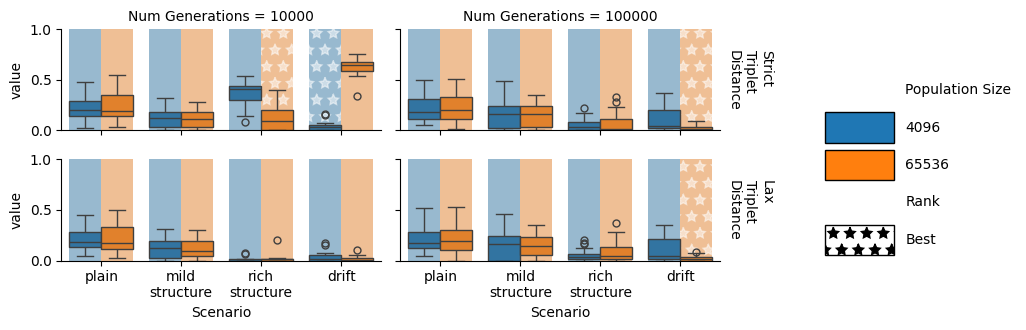

{'Differentia\nWidth\n(bits)': 1,
 'Algorithm': 'surf-hybrid',
 'Annotation\nSize\n(bits)': 64}

/home/runner/.local/lib/python3.10/site-packages/teeplot/teeplot.py:321: UserWarning: teeplot already created file teeplots/algorithm=surf-hybrid+annotation-size-bits=+col=num-generations+differentia-width-bits=+hue=population-size+post=teed-figure-subplots-adjust-right-0-75-teed-set-titles-row-template-row-name+row=variab.../le+score=value+viz=peckplot+x=scenario+x-group=outer+y=value+ext=.pdf, overwriting it
  warnings.warn(


teeplots/algorithm=surf-hybrid+annotation-size-bits=+col=num-generations+differentia-width-bits=+hue=population-size+post=teed-figure-subplots-adjust-right-0-75-teed-set-titles-row-template-row-name+row=variab.../le+score=value+viz=peckplot+x=scenario+x-group=outer+y=value+ext=.pdf


/home/runner/.local/lib/python3.10/site-packages/teeplot/teeplot.py:321: UserWarning: teeplot already created file teeplots/algorithm=surf-hybrid+annotation-size-bits=+col=num-generations+differentia-width-bits=+hue=population-size+post=teed-figure-subplots-adjust-right-0-75-teed-set-titles-row-template-row-name+row=variab.../le+score=value+viz=peckplot+x=scenario+x-group=outer+y=value+ext=.png, overwriting it
  warnings.warn(


teeplots/algorithm=surf-hybrid+annotation-size-bits=+col=num-generations+differentia-width-bits=+hue=population-size+post=teed-figure-subplots-adjust-right-0-75-teed-set-titles-row-template-row-name+row=variab.../le+score=value+viz=peckplot+x=scenario+x-group=outer+y=value+ext=.png


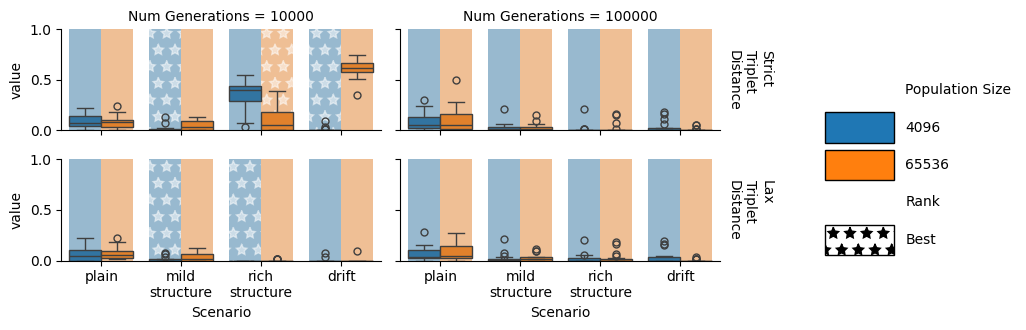

{'Differentia\nWidth\n(bits)': 1,
 'Algorithm': 'surf-hybrid',
 'Annotation\nSize\n(bits)': 256}

teeplots/algorithm=surf-tilted+annotation-size-bits=+col=num-generations+differentia-width-bits=+hue=population-size+post=teed-figure-subplots-adjust-right-0-75-teed-set-titles-row-template-row-name+row=variab.../le+score=value+viz=peckplot+x=scenario+x-group=outer+y=value+ext=.pdf


teeplots/algorithm=surf-tilted+annotation-size-bits=+col=num-generations+differentia-width-bits=+hue=population-size+post=teed-figure-subplots-adjust-right-0-75-teed-set-titles-row-template-row-name+row=variab.../le+score=value+viz=peckplot+x=scenario+x-group=outer+y=value+ext=.png


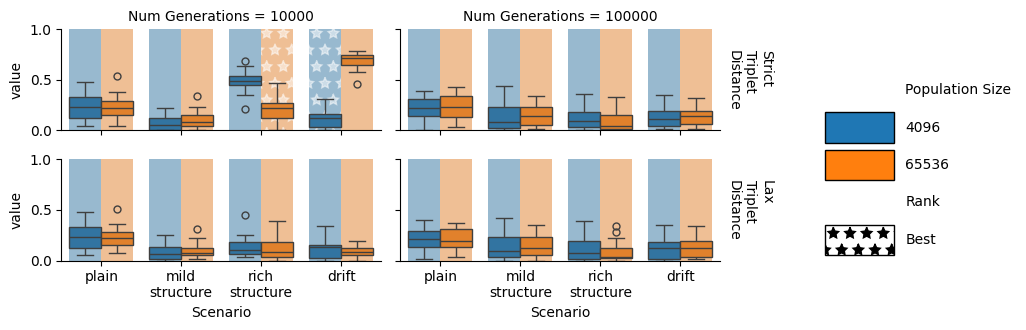

{'Differentia\nWidth\n(bits)': 1,
 'Algorithm': 'surf-tilted',
 'Annotation\nSize\n(bits)': 32}

/home/runner/.local/lib/python3.10/site-packages/teeplot/teeplot.py:321: UserWarning: teeplot already created file teeplots/algorithm=surf-tilted+annotation-size-bits=+col=num-generations+differentia-width-bits=+hue=population-size+post=teed-figure-subplots-adjust-right-0-75-teed-set-titles-row-template-row-name+row=variab.../le+score=value+viz=peckplot+x=scenario+x-group=outer+y=value+ext=.pdf, overwriting it
  warnings.warn(


teeplots/algorithm=surf-tilted+annotation-size-bits=+col=num-generations+differentia-width-bits=+hue=population-size+post=teed-figure-subplots-adjust-right-0-75-teed-set-titles-row-template-row-name+row=variab.../le+score=value+viz=peckplot+x=scenario+x-group=outer+y=value+ext=.pdf


/home/runner/.local/lib/python3.10/site-packages/teeplot/teeplot.py:321: UserWarning: teeplot already created file teeplots/algorithm=surf-tilted+annotation-size-bits=+col=num-generations+differentia-width-bits=+hue=population-size+post=teed-figure-subplots-adjust-right-0-75-teed-set-titles-row-template-row-name+row=variab.../le+score=value+viz=peckplot+x=scenario+x-group=outer+y=value+ext=.png, overwriting it
  warnings.warn(


teeplots/algorithm=surf-tilted+annotation-size-bits=+col=num-generations+differentia-width-bits=+hue=population-size+post=teed-figure-subplots-adjust-right-0-75-teed-set-titles-row-template-row-name+row=variab.../le+score=value+viz=peckplot+x=scenario+x-group=outer+y=value+ext=.png


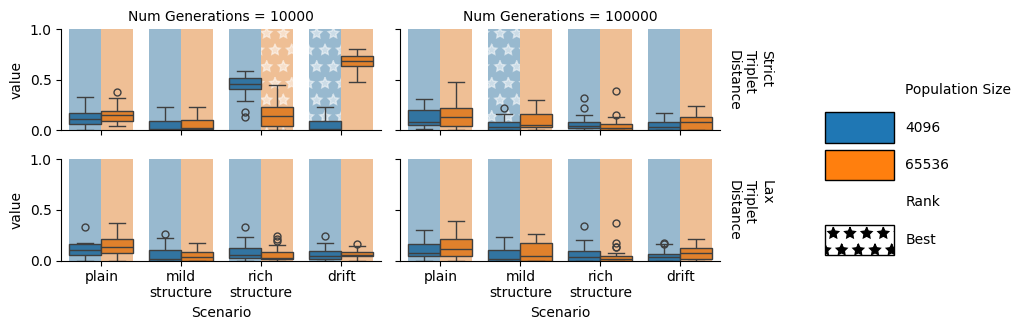

{'Differentia\nWidth\n(bits)': 1,
 'Algorithm': 'surf-tilted',
 'Annotation\nSize\n(bits)': 64}

/home/runner/.local/lib/python3.10/site-packages/teeplot/teeplot.py:321: UserWarning: teeplot already created file teeplots/algorithm=surf-tilted+annotation-size-bits=+col=num-generations+differentia-width-bits=+hue=population-size+post=teed-figure-subplots-adjust-right-0-75-teed-set-titles-row-template-row-name+row=variab.../le+score=value+viz=peckplot+x=scenario+x-group=outer+y=value+ext=.pdf, overwriting it
  warnings.warn(


teeplots/algorithm=surf-tilted+annotation-size-bits=+col=num-generations+differentia-width-bits=+hue=population-size+post=teed-figure-subplots-adjust-right-0-75-teed-set-titles-row-template-row-name+row=variab.../le+score=value+viz=peckplot+x=scenario+x-group=outer+y=value+ext=.pdf


/home/runner/.local/lib/python3.10/site-packages/teeplot/teeplot.py:321: UserWarning: teeplot already created file teeplots/algorithm=surf-tilted+annotation-size-bits=+col=num-generations+differentia-width-bits=+hue=population-size+post=teed-figure-subplots-adjust-right-0-75-teed-set-titles-row-template-row-name+row=variab.../le+score=value+viz=peckplot+x=scenario+x-group=outer+y=value+ext=.png, overwriting it
  warnings.warn(


teeplots/algorithm=surf-tilted+annotation-size-bits=+col=num-generations+differentia-width-bits=+hue=population-size+post=teed-figure-subplots-adjust-right-0-75-teed-set-titles-row-template-row-name+row=variab.../le+score=value+viz=peckplot+x=scenario+x-group=outer+y=value+ext=.png


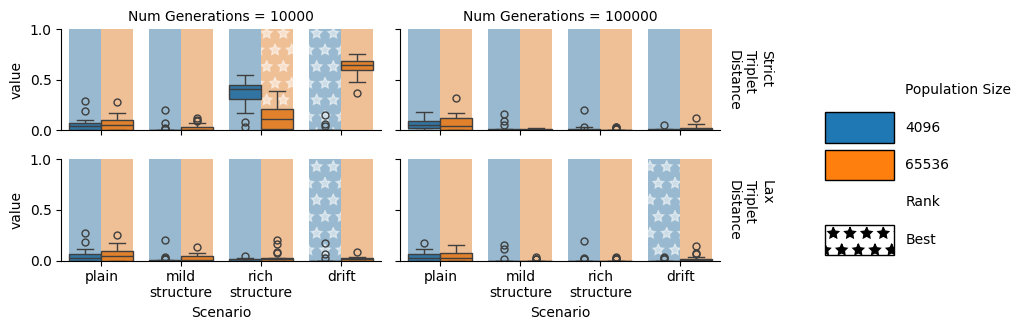

{'Differentia\nWidth\n(bits)': 1,
 'Algorithm': 'surf-tilted',
 'Annotation\nSize\n(bits)': 256}

/home/runner/.local/lib/python3.10/site-packages/pecking/_skim_lowest.py:184: UserWarning: ValueError `All numbers are identical in kruskal` ocurred. No groups skimmed.
  warnings.warn(f"ValueError `{e}` ocurred. No groups skimmed.")
/home/runner/.local/lib/python3.10/site-packages/pecking/_skim_lowest.py:184: UserWarning: ValueError `All numbers are identical in kruskal` ocurred. No groups skimmed.
  warnings.warn(f"ValueError `{e}` ocurred. No groups skimmed.")
/home/runner/.local/lib/python3.10/site-packages/pecking/_skim_lowest.py:184: UserWarning: ValueError `All numbers are identical in kruskal` ocurred. No groups skimmed.
  warnings.warn(f"ValueError `{e}` ocurred. No groups skimmed.")
/home/runner/.local/lib/python3.10/site-packages/pecking/_skim_lowest.py:184: UserWarning: ValueError `All numbers are identical in kruskal` ocurred. No groups skimmed.
  warnings.warn(f"ValueError `{e}` ocurred. No groups skimmed.")
/home/runner/.local/lib/python3.10/site-packages/pecking/_skim_l

/home/runner/.local/lib/python3.10/site-packages/teeplot/teeplot.py:321: UserWarning: teeplot already created file teeplots/algorithm=surf-hybrid+annotation-size-bits=+col=num-generations+differentia-width-bits=+hue=population-size+post=teed-figure-subplots-adjust-right-0-75-teed-set-titles-row-template-row-name+row=variab.../le+score=value+viz=peckplot+x=scenario+x-group=outer+y=value+ext=.pdf, overwriting it
  warnings.warn(


teeplots/algorithm=surf-hybrid+annotation-size-bits=+col=num-generations+differentia-width-bits=+hue=population-size+post=teed-figure-subplots-adjust-right-0-75-teed-set-titles-row-template-row-name+row=variab.../le+score=value+viz=peckplot+x=scenario+x-group=outer+y=value+ext=.pdf


/home/runner/.local/lib/python3.10/site-packages/teeplot/teeplot.py:321: UserWarning: teeplot already created file teeplots/algorithm=surf-hybrid+annotation-size-bits=+col=num-generations+differentia-width-bits=+hue=population-size+post=teed-figure-subplots-adjust-right-0-75-teed-set-titles-row-template-row-name+row=variab.../le+score=value+viz=peckplot+x=scenario+x-group=outer+y=value+ext=.png, overwriting it
  warnings.warn(


teeplots/algorithm=surf-hybrid+annotation-size-bits=+col=num-generations+differentia-width-bits=+hue=population-size+post=teed-figure-subplots-adjust-right-0-75-teed-set-titles-row-template-row-name+row=variab.../le+score=value+viz=peckplot+x=scenario+x-group=outer+y=value+ext=.png


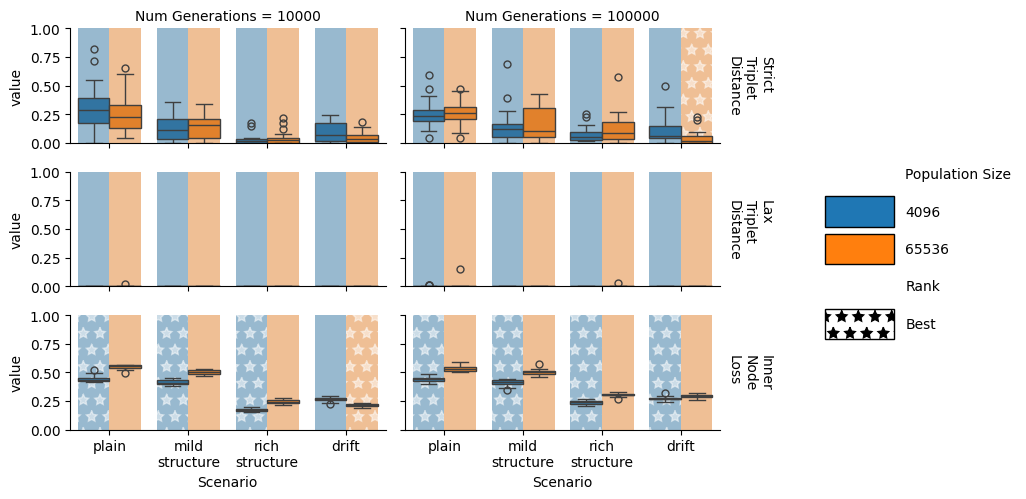

{'Differentia\nWidth\n(bits)': 8,
 'Algorithm': 'surf-hybrid',
 'Annotation\nSize\n(bits)': 256}

/home/runner/.local/lib/python3.10/site-packages/pecking/_skim_lowest.py:184: UserWarning: ValueError `All numbers are identical in kruskal` ocurred. No groups skimmed.
  warnings.warn(f"ValueError `{e}` ocurred. No groups skimmed.")
/home/runner/.local/lib/python3.10/site-packages/pecking/_skim_lowest.py:184: UserWarning: ValueError `All numbers are identical in kruskal` ocurred. No groups skimmed.
  warnings.warn(f"ValueError `{e}` ocurred. No groups skimmed.")
/home/runner/.local/lib/python3.10/site-packages/pecking/_skim_lowest.py:184: UserWarning: ValueError `All numbers are identical in kruskal` ocurred. No groups skimmed.
  warnings.warn(f"ValueError `{e}` ocurred. No groups skimmed.")
/home/runner/.local/lib/python3.10/site-packages/pecking/_skim_lowest.py:184: UserWarning: ValueError `All numbers are identical in kruskal` ocurred. No groups skimmed.
  warnings.warn(f"ValueError `{e}` ocurred. No groups skimmed.")


/home/runner/.local/lib/python3.10/site-packages/teeplot/teeplot.py:321: UserWarning: teeplot already created file teeplots/algorithm=surf-tilted+annotation-size-bits=+col=num-generations+differentia-width-bits=+hue=population-size+post=teed-figure-subplots-adjust-right-0-75-teed-set-titles-row-template-row-name+row=variab.../le+score=value+viz=peckplot+x=scenario+x-group=outer+y=value+ext=.pdf, overwriting it
  warnings.warn(


teeplots/algorithm=surf-tilted+annotation-size-bits=+col=num-generations+differentia-width-bits=+hue=population-size+post=teed-figure-subplots-adjust-right-0-75-teed-set-titles-row-template-row-name+row=variab.../le+score=value+viz=peckplot+x=scenario+x-group=outer+y=value+ext=.pdf


/home/runner/.local/lib/python3.10/site-packages/teeplot/teeplot.py:321: UserWarning: teeplot already created file teeplots/algorithm=surf-tilted+annotation-size-bits=+col=num-generations+differentia-width-bits=+hue=population-size+post=teed-figure-subplots-adjust-right-0-75-teed-set-titles-row-template-row-name+row=variab.../le+score=value+viz=peckplot+x=scenario+x-group=outer+y=value+ext=.png, overwriting it
  warnings.warn(


teeplots/algorithm=surf-tilted+annotation-size-bits=+col=num-generations+differentia-width-bits=+hue=population-size+post=teed-figure-subplots-adjust-right-0-75-teed-set-titles-row-template-row-name+row=variab.../le+score=value+viz=peckplot+x=scenario+x-group=outer+y=value+ext=.png


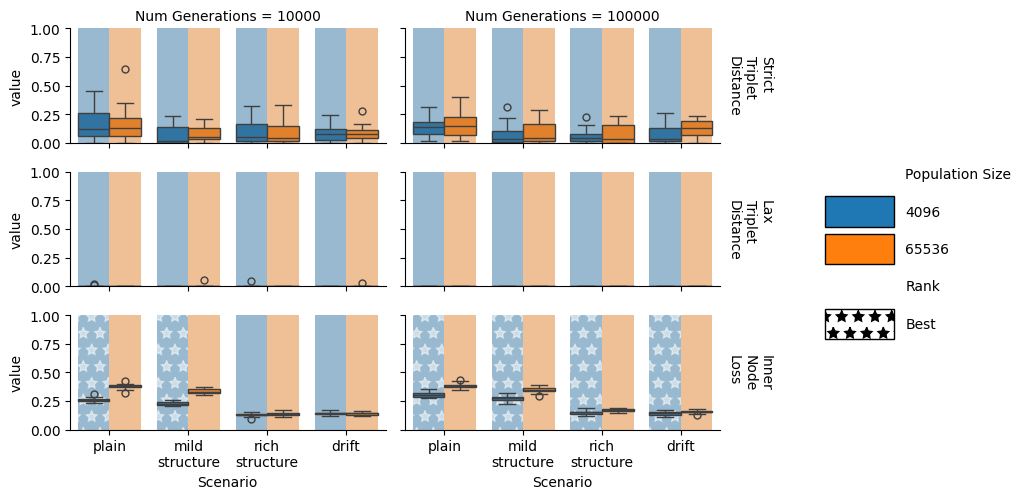

{'Differentia\nWidth\n(bits)': 8,
 'Algorithm': 'surf-tilted',
 'Annotation\nSize\n(bits)': 256}

In [13]:
for name, group in dfx[
    (dfx["downsample"] == 500)
    & (dfx["Algorithm"].isin(["surf-tilted", "surf-hybrid"]))
].groupby(sensitivity_analysis_variables):
    group_variables = dict(zip(sensitivity_analysis_variables, name))

    row_order = [
        "Strict\nTriplet\nDistance",
        "Lax\nTriplet\nDistance",
    ]
    if group_variables["Differentia\nWidth\n(bits)"] > 1:
        row_order.append(
            "Inner\nNode\nLoss",
        )

    tp.tee(
        pecking.peckplot,
        data=group.reset_index(drop=True),
        score="value",
        x="Scenario",
        y="value",
        col="Num Generations",
        row="variable",
        row_order=row_order,
        hue="Population Size",
        x_group="outer",
        order=[
            "plain",
            "mild\nstructure",
            "rich\nstructure",
            "drift",
        ],
        skim_hatches=("*",),
        skim_labels=("Best",),
        skimmers=[pecking.skim_lowest],
        margin_titles=True,
        height=1.7,
        aspect=2.5,
        facet_kws={
            "ylim": (0, 1),
        },
        teeplot_outattrs={
            slugify(k): slugify(v) for k, v in group_variables.items()
        },
        teeplot_outexclude="teeplot_postprocess",
        teeplot_postprocess="teed.figure.subplots_adjust(right=0.75); teed.set_titles(row_template='{row_name}')",
    )
    display(group_variables)


## Visualize Main Metrics -- Downsample


teeplots/algorithm=surf-hybrid+annotation-size-bits=+col=num-generations+differentia-width-bits=+hue=downsample+post=teed-figure-subplots-adjust-right-0-75-teed-set-titles-row-template-row-name+row=variable+sc.../ore=value+viz=peckplot+x=scenario+x-group=outer+y=value+ext=.pdf


teeplots/algorithm=surf-hybrid+annotation-size-bits=+col=num-generations+differentia-width-bits=+hue=downsample+post=teed-figure-subplots-adjust-right-0-75-teed-set-titles-row-template-row-name+row=variable+sc.../ore=value+viz=peckplot+x=scenario+x-group=outer+y=value+ext=.png


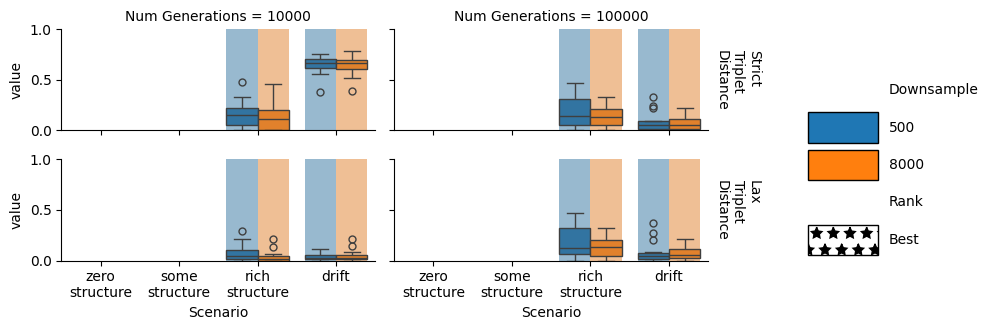

{'Differentia\nWidth\n(bits)': 1,
 'Algorithm': 'surf-hybrid',
 'Annotation\nSize\n(bits)': 32}

/home/runner/.local/lib/python3.10/site-packages/teeplot/teeplot.py:321: UserWarning: teeplot already created file teeplots/algorithm=surf-hybrid+annotation-size-bits=+col=num-generations+differentia-width-bits=+hue=downsample+post=teed-figure-subplots-adjust-right-0-75-teed-set-titles-row-template-row-name+row=variable+sc.../ore=value+viz=peckplot+x=scenario+x-group=outer+y=value+ext=.pdf, overwriting it
  warnings.warn(


teeplots/algorithm=surf-hybrid+annotation-size-bits=+col=num-generations+differentia-width-bits=+hue=downsample+post=teed-figure-subplots-adjust-right-0-75-teed-set-titles-row-template-row-name+row=variable+sc.../ore=value+viz=peckplot+x=scenario+x-group=outer+y=value+ext=.pdf


/home/runner/.local/lib/python3.10/site-packages/teeplot/teeplot.py:321: UserWarning: teeplot already created file teeplots/algorithm=surf-hybrid+annotation-size-bits=+col=num-generations+differentia-width-bits=+hue=downsample+post=teed-figure-subplots-adjust-right-0-75-teed-set-titles-row-template-row-name+row=variable+sc.../ore=value+viz=peckplot+x=scenario+x-group=outer+y=value+ext=.png, overwriting it
  warnings.warn(


teeplots/algorithm=surf-hybrid+annotation-size-bits=+col=num-generations+differentia-width-bits=+hue=downsample+post=teed-figure-subplots-adjust-right-0-75-teed-set-titles-row-template-row-name+row=variable+sc.../ore=value+viz=peckplot+x=scenario+x-group=outer+y=value+ext=.png


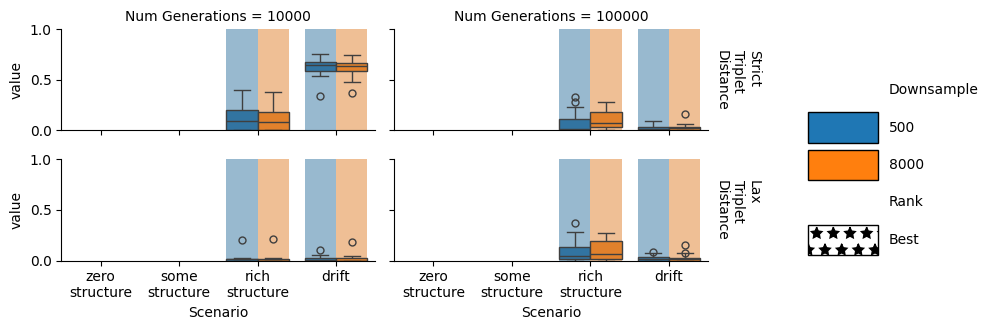

{'Differentia\nWidth\n(bits)': 1,
 'Algorithm': 'surf-hybrid',
 'Annotation\nSize\n(bits)': 64}

/home/runner/.local/lib/python3.10/site-packages/teeplot/teeplot.py:321: UserWarning: teeplot already created file teeplots/algorithm=surf-hybrid+annotation-size-bits=+col=num-generations+differentia-width-bits=+hue=downsample+post=teed-figure-subplots-adjust-right-0-75-teed-set-titles-row-template-row-name+row=variable+sc.../ore=value+viz=peckplot+x=scenario+x-group=outer+y=value+ext=.pdf, overwriting it
  warnings.warn(


teeplots/algorithm=surf-hybrid+annotation-size-bits=+col=num-generations+differentia-width-bits=+hue=downsample+post=teed-figure-subplots-adjust-right-0-75-teed-set-titles-row-template-row-name+row=variable+sc.../ore=value+viz=peckplot+x=scenario+x-group=outer+y=value+ext=.pdf


/home/runner/.local/lib/python3.10/site-packages/teeplot/teeplot.py:321: UserWarning: teeplot already created file teeplots/algorithm=surf-hybrid+annotation-size-bits=+col=num-generations+differentia-width-bits=+hue=downsample+post=teed-figure-subplots-adjust-right-0-75-teed-set-titles-row-template-row-name+row=variable+sc.../ore=value+viz=peckplot+x=scenario+x-group=outer+y=value+ext=.png, overwriting it
  warnings.warn(


teeplots/algorithm=surf-hybrid+annotation-size-bits=+col=num-generations+differentia-width-bits=+hue=downsample+post=teed-figure-subplots-adjust-right-0-75-teed-set-titles-row-template-row-name+row=variable+sc.../ore=value+viz=peckplot+x=scenario+x-group=outer+y=value+ext=.png


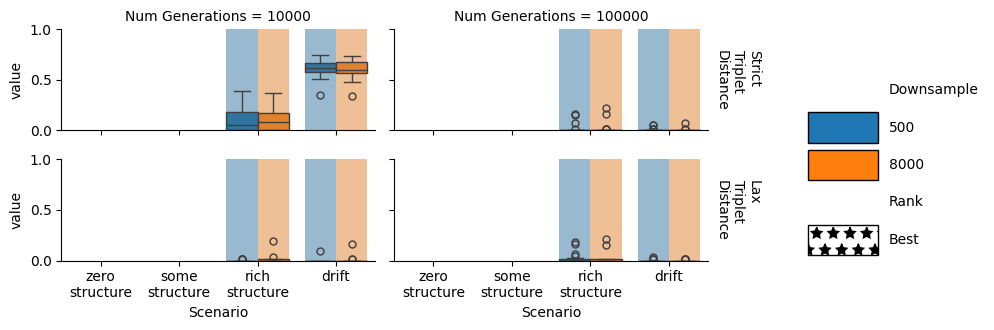

{'Differentia\nWidth\n(bits)': 1,
 'Algorithm': 'surf-hybrid',
 'Annotation\nSize\n(bits)': 256}

teeplots/algorithm=surf-tilted+annotation-size-bits=+col=num-generations+differentia-width-bits=+hue=downsample+post=teed-figure-subplots-adjust-right-0-75-teed-set-titles-row-template-row-name+row=variable+sc.../ore=value+viz=peckplot+x=scenario+x-group=outer+y=value+ext=.pdf


teeplots/algorithm=surf-tilted+annotation-size-bits=+col=num-generations+differentia-width-bits=+hue=downsample+post=teed-figure-subplots-adjust-right-0-75-teed-set-titles-row-template-row-name+row=variable+sc.../ore=value+viz=peckplot+x=scenario+x-group=outer+y=value+ext=.png


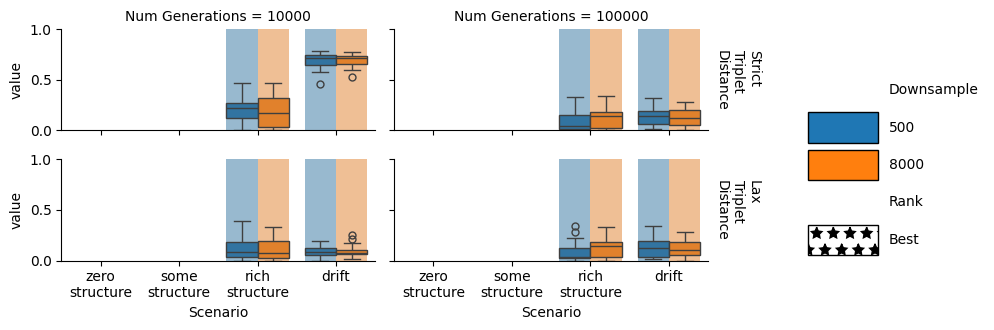

{'Differentia\nWidth\n(bits)': 1,
 'Algorithm': 'surf-tilted',
 'Annotation\nSize\n(bits)': 32}

/home/runner/.local/lib/python3.10/site-packages/teeplot/teeplot.py:321: UserWarning: teeplot already created file teeplots/algorithm=surf-tilted+annotation-size-bits=+col=num-generations+differentia-width-bits=+hue=downsample+post=teed-figure-subplots-adjust-right-0-75-teed-set-titles-row-template-row-name+row=variable+sc.../ore=value+viz=peckplot+x=scenario+x-group=outer+y=value+ext=.pdf, overwriting it
  warnings.warn(


teeplots/algorithm=surf-tilted+annotation-size-bits=+col=num-generations+differentia-width-bits=+hue=downsample+post=teed-figure-subplots-adjust-right-0-75-teed-set-titles-row-template-row-name+row=variable+sc.../ore=value+viz=peckplot+x=scenario+x-group=outer+y=value+ext=.pdf


/home/runner/.local/lib/python3.10/site-packages/teeplot/teeplot.py:321: UserWarning: teeplot already created file teeplots/algorithm=surf-tilted+annotation-size-bits=+col=num-generations+differentia-width-bits=+hue=downsample+post=teed-figure-subplots-adjust-right-0-75-teed-set-titles-row-template-row-name+row=variable+sc.../ore=value+viz=peckplot+x=scenario+x-group=outer+y=value+ext=.png, overwriting it
  warnings.warn(


teeplots/algorithm=surf-tilted+annotation-size-bits=+col=num-generations+differentia-width-bits=+hue=downsample+post=teed-figure-subplots-adjust-right-0-75-teed-set-titles-row-template-row-name+row=variable+sc.../ore=value+viz=peckplot+x=scenario+x-group=outer+y=value+ext=.png


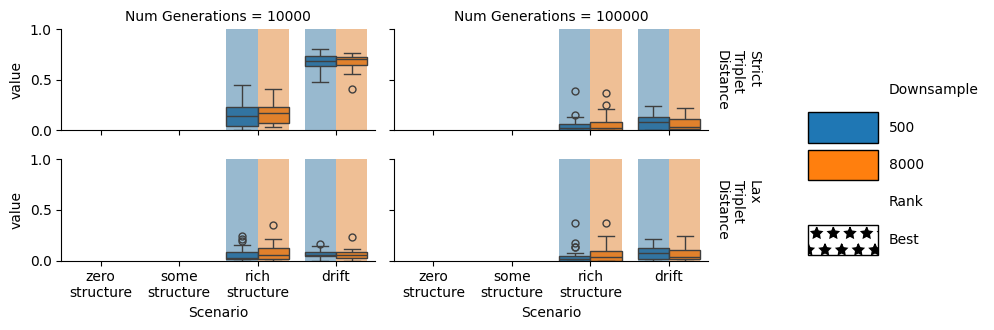

{'Differentia\nWidth\n(bits)': 1,
 'Algorithm': 'surf-tilted',
 'Annotation\nSize\n(bits)': 64}

/home/runner/.local/lib/python3.10/site-packages/teeplot/teeplot.py:321: UserWarning: teeplot already created file teeplots/algorithm=surf-tilted+annotation-size-bits=+col=num-generations+differentia-width-bits=+hue=downsample+post=teed-figure-subplots-adjust-right-0-75-teed-set-titles-row-template-row-name+row=variable+sc.../ore=value+viz=peckplot+x=scenario+x-group=outer+y=value+ext=.pdf, overwriting it
  warnings.warn(


teeplots/algorithm=surf-tilted+annotation-size-bits=+col=num-generations+differentia-width-bits=+hue=downsample+post=teed-figure-subplots-adjust-right-0-75-teed-set-titles-row-template-row-name+row=variable+sc.../ore=value+viz=peckplot+x=scenario+x-group=outer+y=value+ext=.pdf


/home/runner/.local/lib/python3.10/site-packages/teeplot/teeplot.py:321: UserWarning: teeplot already created file teeplots/algorithm=surf-tilted+annotation-size-bits=+col=num-generations+differentia-width-bits=+hue=downsample+post=teed-figure-subplots-adjust-right-0-75-teed-set-titles-row-template-row-name+row=variable+sc.../ore=value+viz=peckplot+x=scenario+x-group=outer+y=value+ext=.png, overwriting it
  warnings.warn(


teeplots/algorithm=surf-tilted+annotation-size-bits=+col=num-generations+differentia-width-bits=+hue=downsample+post=teed-figure-subplots-adjust-right-0-75-teed-set-titles-row-template-row-name+row=variable+sc.../ore=value+viz=peckplot+x=scenario+x-group=outer+y=value+ext=.png


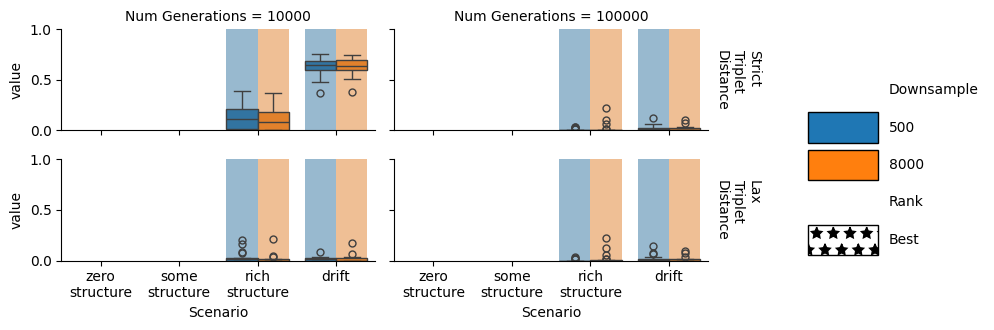

{'Differentia\nWidth\n(bits)': 1,
 'Algorithm': 'surf-tilted',
 'Annotation\nSize\n(bits)': 256}

/home/runner/.local/lib/python3.10/site-packages/pecking/_skim_lowest.py:184: UserWarning: ValueError `All numbers are identical in kruskal` ocurred. No groups skimmed.
  warnings.warn(f"ValueError `{e}` ocurred. No groups skimmed.")
/home/runner/.local/lib/python3.10/site-packages/pecking/_skim_lowest.py:184: UserWarning: ValueError `All numbers are identical in kruskal` ocurred. No groups skimmed.
  warnings.warn(f"ValueError `{e}` ocurred. No groups skimmed.")


/home/runner/.local/lib/python3.10/site-packages/teeplot/teeplot.py:321: UserWarning: teeplot already created file teeplots/algorithm=surf-hybrid+annotation-size-bits=+col=num-generations+differentia-width-bits=+hue=downsample+post=teed-figure-subplots-adjust-right-0-75-teed-set-titles-row-template-row-name+row=variable+sc.../ore=value+viz=peckplot+x=scenario+x-group=outer+y=value+ext=.pdf, overwriting it
  warnings.warn(


teeplots/algorithm=surf-hybrid+annotation-size-bits=+col=num-generations+differentia-width-bits=+hue=downsample+post=teed-figure-subplots-adjust-right-0-75-teed-set-titles-row-template-row-name+row=variable+sc.../ore=value+viz=peckplot+x=scenario+x-group=outer+y=value+ext=.pdf


/home/runner/.local/lib/python3.10/site-packages/teeplot/teeplot.py:321: UserWarning: teeplot already created file teeplots/algorithm=surf-hybrid+annotation-size-bits=+col=num-generations+differentia-width-bits=+hue=downsample+post=teed-figure-subplots-adjust-right-0-75-teed-set-titles-row-template-row-name+row=variable+sc.../ore=value+viz=peckplot+x=scenario+x-group=outer+y=value+ext=.png, overwriting it
  warnings.warn(


teeplots/algorithm=surf-hybrid+annotation-size-bits=+col=num-generations+differentia-width-bits=+hue=downsample+post=teed-figure-subplots-adjust-right-0-75-teed-set-titles-row-template-row-name+row=variable+sc.../ore=value+viz=peckplot+x=scenario+x-group=outer+y=value+ext=.png


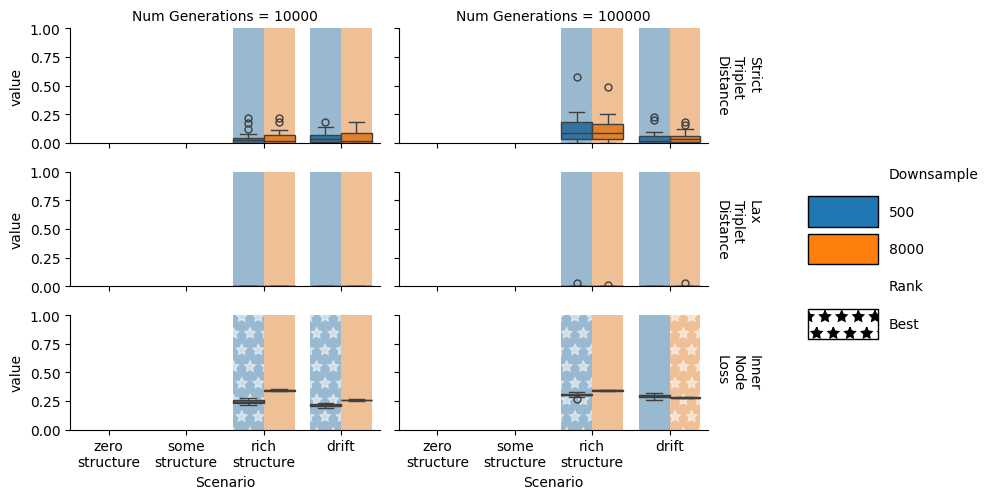

{'Differentia\nWidth\n(bits)': 8,
 'Algorithm': 'surf-hybrid',
 'Annotation\nSize\n(bits)': 256}

/home/runner/.local/lib/python3.10/site-packages/pecking/_skim_lowest.py:184: UserWarning: ValueError `All numbers are identical in kruskal` ocurred. No groups skimmed.
  warnings.warn(f"ValueError `{e}` ocurred. No groups skimmed.")
/home/runner/.local/lib/python3.10/site-packages/pecking/_skim_lowest.py:184: UserWarning: ValueError `All numbers are identical in kruskal` ocurred. No groups skimmed.
  warnings.warn(f"ValueError `{e}` ocurred. No groups skimmed.")


/home/runner/.local/lib/python3.10/site-packages/teeplot/teeplot.py:321: UserWarning: teeplot already created file teeplots/algorithm=surf-tilted+annotation-size-bits=+col=num-generations+differentia-width-bits=+hue=downsample+post=teed-figure-subplots-adjust-right-0-75-teed-set-titles-row-template-row-name+row=variable+sc.../ore=value+viz=peckplot+x=scenario+x-group=outer+y=value+ext=.pdf, overwriting it
  warnings.warn(


teeplots/algorithm=surf-tilted+annotation-size-bits=+col=num-generations+differentia-width-bits=+hue=downsample+post=teed-figure-subplots-adjust-right-0-75-teed-set-titles-row-template-row-name+row=variable+sc.../ore=value+viz=peckplot+x=scenario+x-group=outer+y=value+ext=.pdf


/home/runner/.local/lib/python3.10/site-packages/teeplot/teeplot.py:321: UserWarning: teeplot already created file teeplots/algorithm=surf-tilted+annotation-size-bits=+col=num-generations+differentia-width-bits=+hue=downsample+post=teed-figure-subplots-adjust-right-0-75-teed-set-titles-row-template-row-name+row=variable+sc.../ore=value+viz=peckplot+x=scenario+x-group=outer+y=value+ext=.png, overwriting it
  warnings.warn(


teeplots/algorithm=surf-tilted+annotation-size-bits=+col=num-generations+differentia-width-bits=+hue=downsample+post=teed-figure-subplots-adjust-right-0-75-teed-set-titles-row-template-row-name+row=variable+sc.../ore=value+viz=peckplot+x=scenario+x-group=outer+y=value+ext=.png


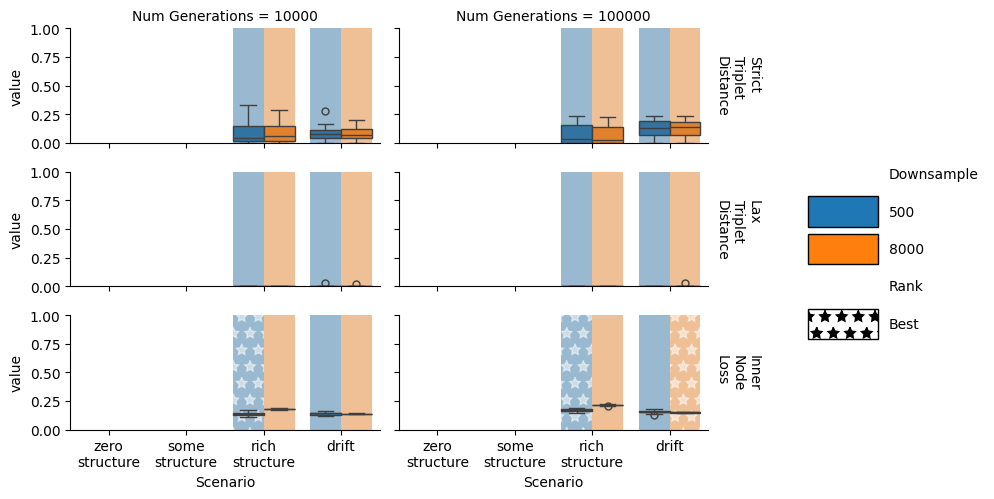

{'Differentia\nWidth\n(bits)': 8,
 'Algorithm': 'surf-tilted',
 'Annotation\nSize\n(bits)': 256}

In [14]:
for name, group in dfx[
    (dfx["Population Size"] == 65536)
    & (dfx["Algorithm"].isin(["surf-tilted", "surf-hybrid"]))
].groupby(sensitivity_analysis_variables):
    group_variables = dict(zip(sensitivity_analysis_variables, name))

    row_order = [
        "Strict\nTriplet\nDistance",
        "Lax\nTriplet\nDistance",
    ]
    if group_variables["Differentia\nWidth\n(bits)"] > 1:
        row_order.append(
            "Inner\nNode\nLoss",
        )

    tp.tee(
        pecking.peckplot,
        data=group.reset_index(drop=True),
        score="value",
        x="Scenario",
        y="value",
        col="Num Generations",
        row="variable",
        row_order=row_order,
        hue="Downsample",
        x_group="outer",
        order=[
            "zero\nstructure",
            "some\nstructure",
            "rich\nstructure",
            "drift",
        ],
        skim_hatches=("*",),
        skim_labels=("Best",),
        skimmers=[pecking.skim_lowest],
        margin_titles=True,
        height=1.7,
        aspect=2.5,
        facet_kws={
            "ylim": (0, 1),
        },
        teeplot_outattrs={
            slugify(k): slugify(v) for k, v in group_variables.items()
        },
        teeplot_outexclude="teeplot_postprocess",
        teeplot_postprocess="teed.figure.subplots_adjust(right=0.75); teed.set_titles(row_template='{row_name}')",
    )
    display(group_variables)


## Make Stat Table


In [15]:
lookup_effect = {}


def cached_delta(x, y):
    d = -cliffs_delta(x, y)[0]
    lookup_effect[d] = describe_effect(x, y)
    return d


vars = [
    "Policy",
    "Scenario",
    *sensitivity_analysis_variables,
    "Num Generations",
    "Algorithm",
]

records = []
for name, group in (
    df[
        (df["downsample"] == 500)
    ]
    .reset_index()
    .groupby(vars)
):
    group_variables = dict(zip(vars, name))
    records.append(
        {
            **group_variables,
            **{
                "Strict<br/>Triplet<br/>Distance": cached_delta(
                    group[group["Population Size"] == 4096][
                        "Strict Triplet Distance"
                    ],
                    group[group["Population Size"] == 65536][
                        "Strict Triplet Distance"
                    ],
                ),
                "Lax<br/>Triplet<br/>Distance": cached_delta(
                    group[group["Population Size"] == 4096][
                        "Lax Triplet Distance"
                    ],
                    group[group["Population Size"] == 65536][
                        "Lax Triplet Distance"
                    ],
                ),
                "Inner<br/>Node<br/>Loss": (
                    cached_delta(
                        group[group["Population Size"] == 4096][
                            "Inner Node Loss"
                        ],
                        group[group["Population Size"] == 65536][
                            "Inner Node Loss"
                        ],
                    )
                    # if group_variables["Differentia\nWidth\n(bits)"] > 1
                    # else float("nan")
                ),
            },
            "Scaling Factor": "Population Size",
        }
    )

for name, group in (
    df[
        (df["Population Size"] == 65536)
    ]
    .reset_index()
    .groupby(vars)
):
    group_variables = dict(zip(vars, name))
    records.append(
        {
            **group_variables,
            **{
                "Strict<br/>Triplet<br/>Distance": cached_delta(
                    group[group["Downsample"] == 500][
                        "Strict Triplet Distance"
                    ],
                    group[group["Downsample"] == 8000][
                        "Strict Triplet Distance"
                    ],
                ),
                "Lax<br/>Triplet<br/>Distance": cached_delta(
                    group[group["Downsample"] == 500]["Lax Triplet Distance"],
                    group[group["Downsample"] == 8000]["Lax Triplet Distance"],
                ),
                "Inner<br/>Node<br/>Loss": (
                    cached_delta(
                        group[group["Downsample"] == 500]["Inner Node Loss"],
                        group[group["Downsample"] == 8000]["Inner Node Loss"],
                    )
                    # if group_variables["Differentia\nWidth\n(bits)"] > 1
                    # else float("nan")
                ),
            },
            "Scaling Factor": "Sample Size",
        }
    )


dfr = pd.DataFrame.from_records(records)
dfr


,Policy,Scenario,Differentia\nWidth\n(bits),Algorithm,Annotation\nSize\n(bits),Num Generations,Strict<br/>Triplet<br/>Distance,Lax<br/>Triplet<br/>Distance,Inner<br/>Node<br/>Loss,Scaling Factor
0,Hybrid,drift,1,surf-hybrid,32,10000,0.9950,-0.3925,-1.0000,Population Size
1,Hybrid,drift,1,surf-hybrid,32,100000,-0.4275,-0.4875,-1.0000,Population Size
2,Hybrid,drift,1,surf-hybrid,64,10000,1.0000,-0.2325,-1.0000,Population Size
3,Hybrid,drift,1,surf-hybrid,64,100000,-0.4600,-0.4375,-0.1025,Population Size
4,Hybrid,drift,1,surf-hybrid,256,10000,1.0000,-0.0450,-1.0000,Population Size
...,...,...,...,...,...,...,...,...,...,...
315,Tilted,rich\nstructure,1,surf-tilted,256,100000,0.0225,0.0700,0.5200,Sample Size
316,Tilted,rich\nstructure,8,col-tilted,256,10000,-0.0400,-0.0000,0.2750,Sample Size
317,Tilted,rich\nstructure,8,col-tilted,256,100000,0.0400,-0.0000,1.0000,Sample Size
318,Tilted,rich\nstructure,8,surf-tilted,256,10000,0.0225,-0.0000,1.0000,Sample Size


In [16]:
cmap = mpl.colormaps.get_cmap("coolwarm")
cmap.set_bad(color="white")


In [17]:
dfr["Unit"] = dfr["Differentia\nWidth\n(bits)"].map({1: "bit", 8: "byte"})
dfr["Size<br/>(bits)"] = dfr["Annotation\nSize\n(bits)"]


## Draw Stat Table --- tilted


In [18]:
vars = [
    "Scaling Factor",
    "Scenario",
    "Unit",
    # "Num Generations",
    "Size<br/>(bits)",
]
styled_dfs = (
    dfr[
        (dfr["Num Generations"] == 100000)
        & (dfr["Algorithm"].isin(["surf-tilted"]))
    ]
    .set_index(vars)
    .unstack(level=0)[
        [
            "Strict<br/>Triplet<br/>Distance",
            "Lax<br/>Triplet<br/>Distance",
            "Inner<br/>Node<br/>Loss",
        ]
    ]
    .swaplevel(axis="columns")
    .sort_index(axis=1, level=0, ascending=False)
    .style.background_gradient(cmap=cmap, vmin=-1, vmax=1, axis=None)
    .format(lambda x: lookup_effect.get(x, "n/a"))
)

props = [
    ("cellpadding", "0px"),
    ("cellspacing", "0px"),
    ("border", "1px solid black"),
    ("border-collapse", "collapse"),
    ("max-width", "80px !important"),
    ("word-wrap", "break-word"),
]
moreprops = [
    *props,
    ("padding-top", "0px"),
    ("padding-bottom", "0px"),
    ("margin", "0px"),
    ("height", "0px"),
]
smallprops = [
    *moreprops,
    ("font-size", "9px"),
    ("text-align", "center"),
    ("width", "65px"),
]
bigprops = [
    *moreprops,
    ("font-size", "11px"),
    ("color", "white"),
    ("background-color", "DimGray"),
]

divider_style = [
    # Header cell borders
    {"selector": "th", "props": bigprops},
    # Data cell borders
    {"selector": "td", "props": smallprops},
    # Row borders
    {"selector": "tr", "props": smallprops},
]
styled_dfs = styled_dfs.set_table_styles(divider_style).set_table_attributes(
    'style="cellspacing:0;border-collapse:collapse;font-family:sans-serif;"'
)

styled_dfs


In [19]:
os.makedirs("outplots", exist_ok=True)
styler_to_pdf(styled_dfs, "outplots/dsamp-popsize-scale-tilted.pdf")


inkscape output:
 
** (inkscape:6633): WARNING **: 02:03:54.821: No pages selected, getting first page only.

** (inkscape:6633): WARNING **: 02:03:54.978: Failed to wrap object of type 'GtkRecentManager'. Hint: this error is commonly caused by failing to call a library init() function.



## Draw Stat Table --- hybrid


In [20]:
vars = [
    "Scaling Factor",
    "Scenario",
    "Unit",
    # "Num Generations",
    "Size<br/>(bits)",
]
styled_dfs = (
    dfr[
        (dfr["Num Generations"] == 100000)
        & (dfr["Algorithm"].isin(["surf-hybrid"]))
    ]
    .set_index(vars)
    .unstack(level=0)[
        [
            "Strict<br/>Triplet<br/>Distance",
            "Lax<br/>Triplet<br/>Distance",
            "Inner<br/>Node<br/>Loss",
        ]
    ]
    .swaplevel(axis="columns")
    .sort_index(axis=1, level=0, ascending=False)
    .style.background_gradient(cmap=cmap, vmin=-1, vmax=1, axis=None)
    .format(lambda x: lookup_effect.get(x, "n/a"))
)

props = [
    ("cellpadding", "0px"),
    ("cellspacing", "0px"),
    ("border", "1px solid black"),
    ("border-collapse", "collapse"),
    ("max-width", "80px !important"),
    ("word-wrap", "break-word"),
]
moreprops = [
    *props,
    ("padding-top", "0px"),
    ("padding-bottom", "0px"),
    ("margin", "0px"),
    ("height", "0px"),
]
smallprops = [
    *moreprops,
    ("font-size", "9px"),
    ("text-align", "center"),
    ("width", "65px"),
]
bigprops = [
    *moreprops,
    ("font-size", "11px"),
    ("color", "white"),
    ("background-color", "DimGray"),
]

divider_style = [
    # Header cell borders
    {"selector": "th", "props": bigprops},
    # Data cell borders
    {"selector": "td", "props": smallprops},
    # Row borders
    {"selector": "tr", "props": smallprops},
]
styled_dfs = styled_dfs.set_table_styles(divider_style).set_table_attributes(
    'style="cellspacing:0;border-collapse:collapse;font-family:sans-serif;"'
)

styled_dfs


In [21]:
os.makedirs("outplots", exist_ok=True)
styler_to_pdf(styled_dfs, "outplots/dsamp-popsize-scale-hybrid.pdf")


inkscape output:
 
** (inkscape:6655): WARNING **: 02:03:55.614: No pages selected, getting first page only.

** (inkscape:6655): WARNING **: 02:03:55.761: Failed to wrap object of type 'GtkRecentManager'. Hint: this error is commonly caused by failing to call a library init() function.



## Reproducibility


In [22]:
datetime.datetime.now().isoformat()


'2024-04-09T02:03:55.944550'

In [23]:
%load_ext watermark
%watermark


Last updated: 2024-04-09T02:03:55.956191+00:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.22.1

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.5.0-1017-azure
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit



In [24]:
!pip freeze


alifedata-phyloinformatics-convert==0.16.2
annotated-types==0.6.0
anytree==2.12.1
appdirs==1.4.4
argcomplete==3.2.3
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
asttokens==2.4.1
attrs==23.2.0
Automat==20.2.0
Babel==2.8.0
backstrip==0.2.4
bcrypt==3.2.0
beautifulsoup4==4.12.3
biopython==1.83
bitarray==2.9.2
bitstring==4.1.4
black==22.10.0
bleach==6.1.0
blinker==1.4
Brotli==1.1.0
CacheControl==0.12.10
certifi==2024.2.2
cffi==1.16.0
chardet==4.0.0
charset-normalizer==3.3.2
click==8.1.7
cliffs-delta==1.0.0
cloud-init==23.4.4
colorama==0.4.4
comm==0.2.1
command-not-found==0.3
configobj==5.0.6
constantly==15.1.0
contourpy==1.2.0
cryptography==3.4.8
cssselect==1.1.0
cssselect2==0.7.0
cycler==0.12.1
dataclasses==0.6
dbus-python==1.2.18
debugpy==1.8.1
decorator==5.1.1
defusedxml==0.7.1
DendroPy==4.6.1
Deprecated==1.2.14
distro==1.7.0
distro-info==1.1+ubuntu0.2
distutils-strtobool==0.1.0
entrypoints==0.4
ete3==3.1.3
exceptiongroup==1.2.0
executing==2.0.1
fastjsonschema==2.19.1
fonttools==4.49

In [25]:
!inkscape --version


Inkscape 1.3.2 (1:1.3.2+202311252150+091e20ef0f)
